In [6]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [9]:
path = 'dataset_corrected/'
x1_train = pd.read_csv(path+'c_data_x1_train.csv')
x2_train = pd.read_csv(path+'c_data_x2_train.csv')
f1_train = pd.read_csv(path+'c_data_f1_train.csv')
f1_test = pd.read_csv(path+'c_data_f1_test.csv')
x1_test = pd.read_csv(path+'c_data_x1_test.csv')
x2_test = pd.read_csv(path+'c_data_x2_test.csv')

X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1))
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1))
X_train.head()

,0,1
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [10]:
from scipy import *
from scipy.linalg import norm, pinv
import math
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [11]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    # RBF MODEL
    rbf = RBF(2*m, 100, 1)
    t1 = datetime.now()
    rbf.train(x_train, y_train)
    t2 = datetime.now()
    
    print('\n\nTime taken by RBF Model: ',t2-t1)
    y1_pred = rbf.test(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    
    # GRADIENT BOOSTING
    gb = GradientBoostingRegressor()
    t1 = datetime.now()
    gb.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Gradient Boosting:',t2-t1)

    y1_pred = gb.predict(x_test)
    print('Root mean square error of Gradient Boosting Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    y3 = y1_pred

    error9 = []
    for i in range(len(y_test)):
        error9.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error9))
    print('Maximum Error =',max(error9))
    error8 = sorted(error9)
    print('Median Value of Error =',error8[len(error9)//2])

    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y3[:6000], label = 'Gradient Boosting')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()

    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error9[:6000], label = 'Gradient Boosting')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # CatBoost model
    cat = CatBoostRegressor()
    t1 = datetime.now()
    cat.fit(x_train,y_train)
    t2 = datetime.now()
    print('\n\n\nTime taken by Cat Boosting:',t2-t1)

    y_pred = cat.predict(x_test)
    print('Root mean square error of Cat Boost Model: ',sqrt(mean_squared_error(y_test,y_pred)))
    
    error_cat = []
    for i in range(len(y_test)):
        error_cat.append(abs(y_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error_cat))
    print('Maximum Error =',max(error_cat))
    error8 = sorted(error_cat)
    print('Median Value of Error =',error8[len(error8)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y_pred[:6000], label = 'Cat Boost')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    # Error plots
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error9[:6000], label = 'Gradient Boosting Model')
    plt.plot(list(range(6000)),error_cat[:6000], label = 'Cat Boosting Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()

# Results

Time taken by Random Forest 0:01:48.620022
Root Mean Squared error of Random Forest 0.06255690035951753
Minimum Error = 2.220446049250313e-16
Maximum Error = 0.9111610000000014
Median Value of Error = 0.020603000000000038


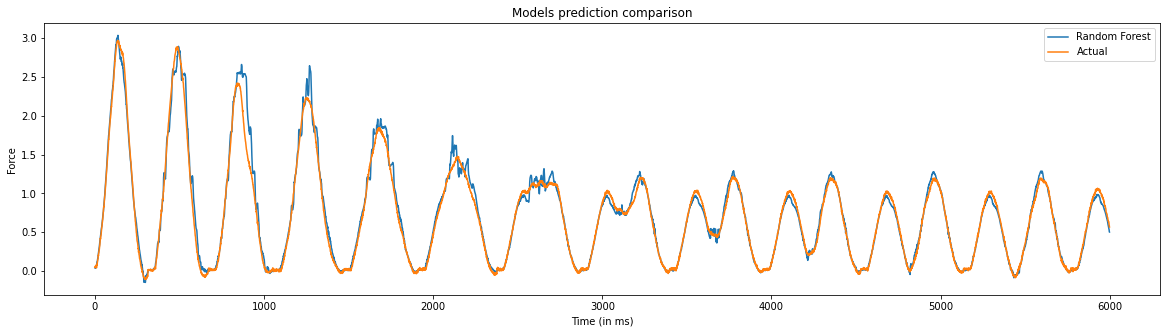



Time taken by RBF Model:  0:02:02.246361
Root mean square error of RBF Model:  0.047838915646003864
Minimum Error = [3.20004462e-07]
Maximum Error = [0.68697881]
Median Value of Error = [0.02088097]


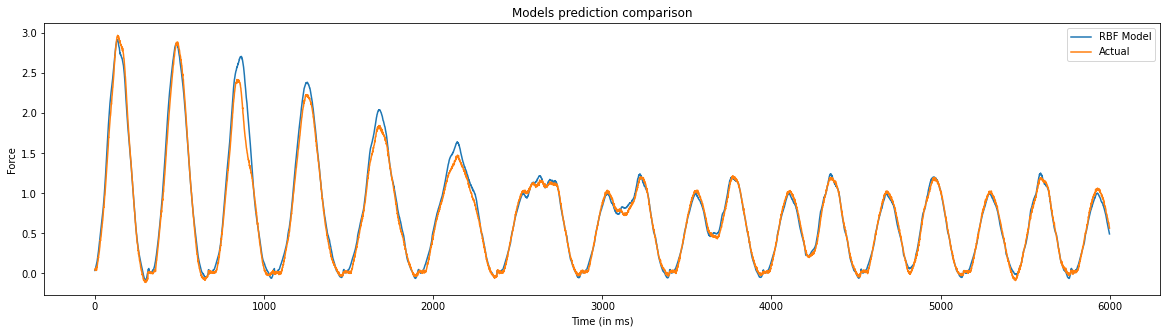

Time taken by Gradient Boosting: 0:00:33.725754
Root mean square error of Gradient Boosting Model:  0.0658868374317265
Minimum Error = 4.103261493297594e-06
Maximum Error = 1.0918031062820648
Median Value of Error = 0.0312086230889721


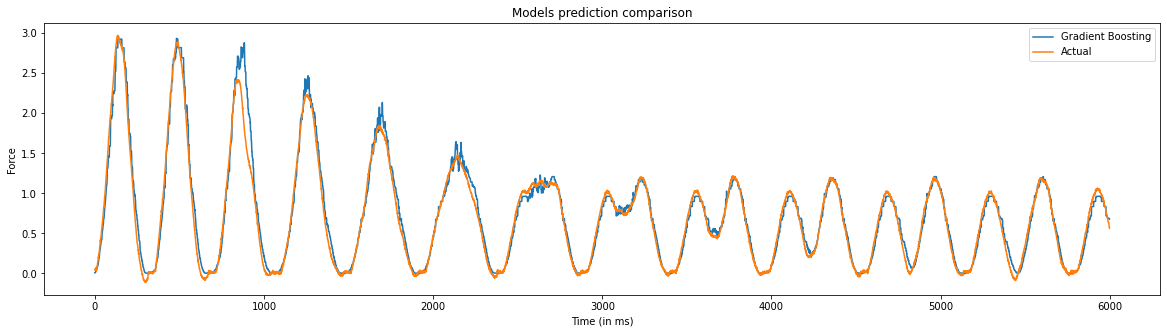

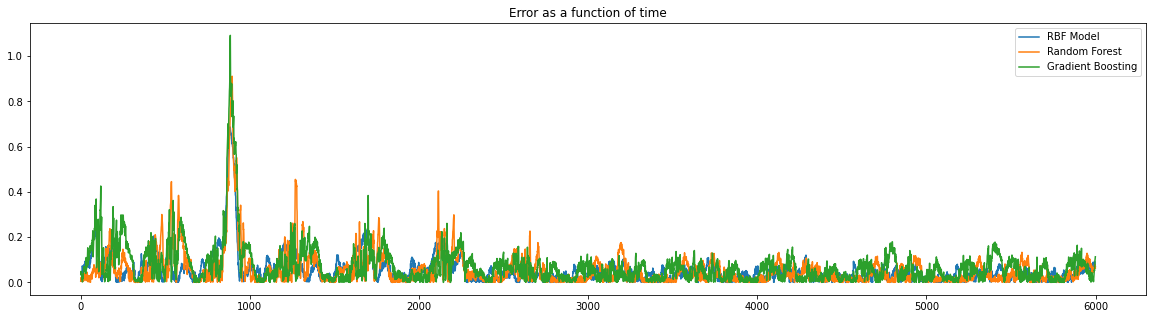

Learning rate set to 0.08682
0:	learn: 0.9230278	total: 58.5ms	remaining: 58.5s
1:	learn: 0.8475018	total: 64.8ms	remaining: 32.3s
2:	learn: 0.7784170	total: 71.2ms	remaining: 23.7s
3:	learn: 0.7149872	total: 77.4ms	remaining: 19.3s
4:	learn: 0.6572514	total: 83.6ms	remaining: 16.6s
5:	learn: 0.6051038	total: 89.7ms	remaining: 14.9s
6:	learn: 0.5565667	total: 95.6ms	remaining: 13.6s
7:	learn: 0.5121494	total: 102ms	remaining: 12.6s
8:	learn: 0.4716580	total: 108ms	remaining: 11.9s
9:	learn: 0.4346903	total: 113ms	remaining: 11.2s
10:	learn: 0.4014555	total: 119ms	remaining: 10.7s
11:	learn: 0.3708109	total: 124ms	remaining: 10.2s
12:	learn: 0.3430031	total: 130ms	remaining: 9.85s
13:	learn: 0.3174651	total: 135ms	remaining: 9.54s
14:	learn: 0.2946413	total: 140ms	remaining: 9.22s
15:	learn: 0.2734802	total: 146ms	remaining: 8.95s
16:	learn: 0.2540525	total: 151ms	remaining: 8.75s
17:	learn: 0.2370674	total: 157ms	remaining: 8.54s
18:	learn: 0.2215229	total: 162ms	remaining: 8.38s
19:	l

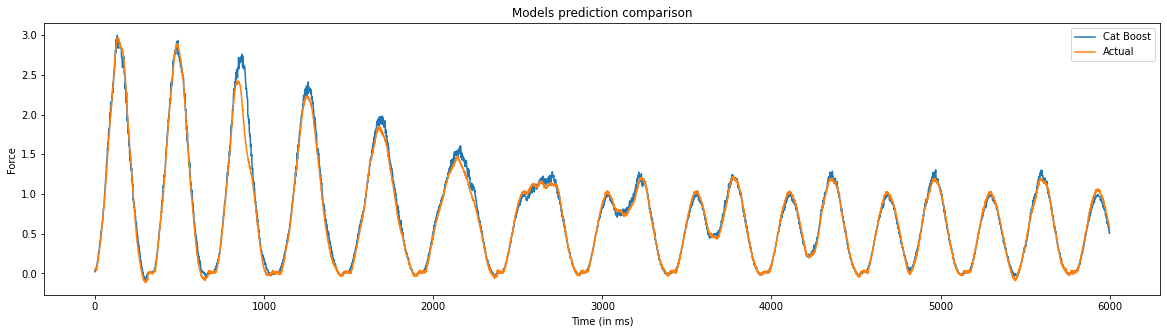

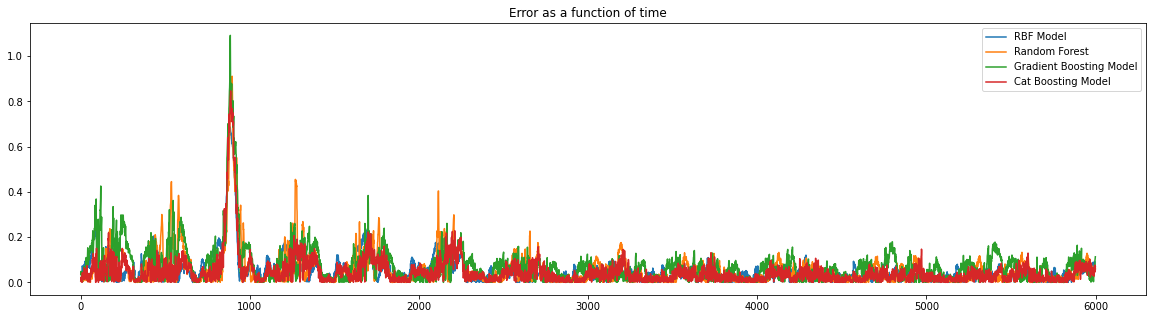

In [12]:
get_results(t=4,m=5)

Time taken by Random Forest 0:01:28.743576
Root Mean Squared error of Random Forest 0.06273927744557027
Minimum Error = 2.220446049250313e-16
Maximum Error = 0.9110400000000018
Median Value of Error = 0.020510999999999946


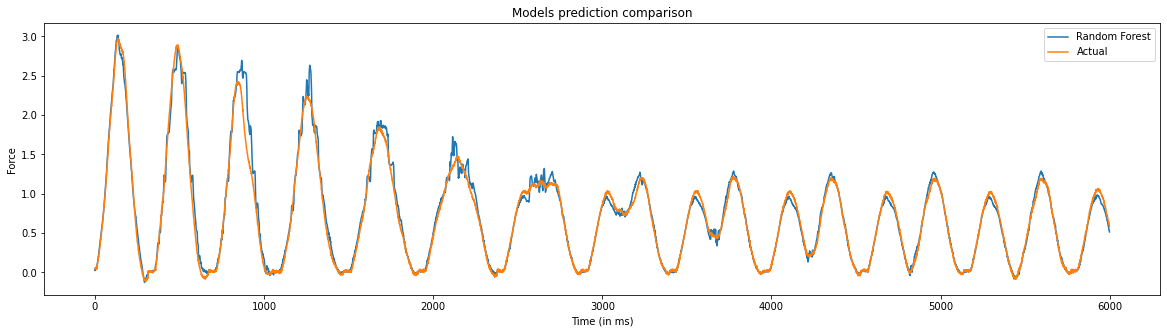



Time taken by RBF Model:  0:02:13.549010
Root mean square error of RBF Model:  0.04806279158480047
Minimum Error = [3.56887339e-07]
Maximum Error = [0.72766428]
Median Value of Error = [0.02130098]


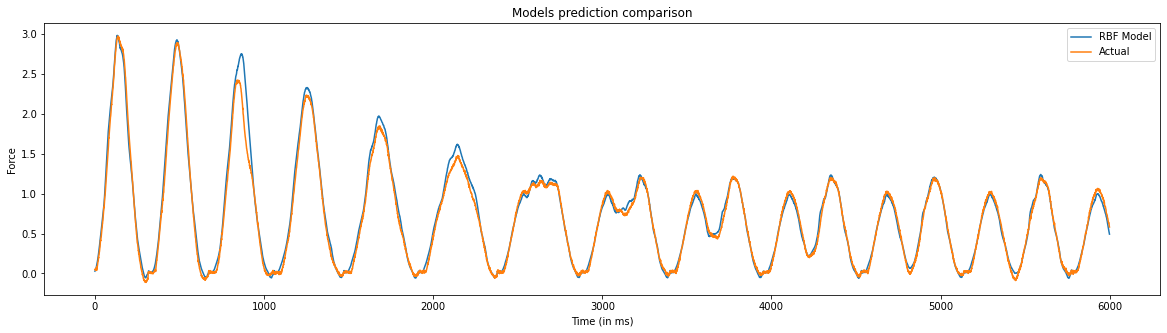

Time taken by Gradient Boosting: 0:00:27.261702
Root mean square error of Gradient Boosting Model:  0.06653502151238473
Minimum Error = 8.060044616106654e-08
Maximum Error = 0.9693193078841227
Median Value of Error = 0.030913863524889187


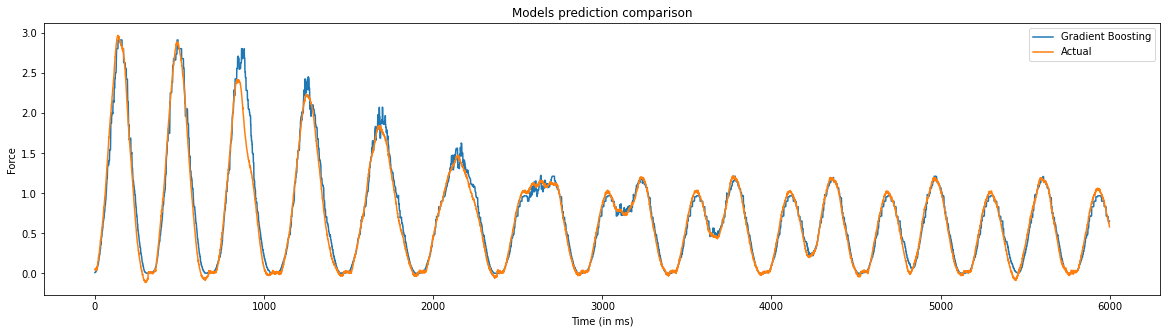

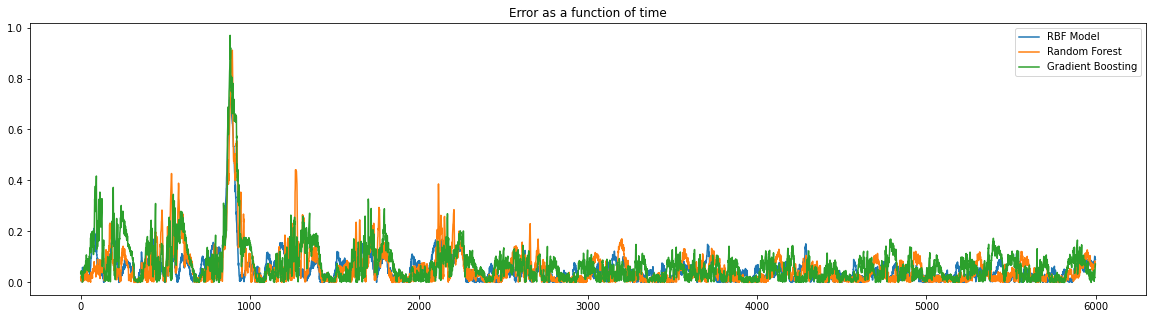

Learning rate set to 0.08682
0:	learn: 0.9237199	total: 11.3ms	remaining: 11.3s
1:	learn: 0.8479172	total: 17.2ms	remaining: 8.58s
2:	learn: 0.7784135	total: 22.5ms	remaining: 7.47s
3:	learn: 0.7151262	total: 27.4ms	remaining: 6.83s
4:	learn: 0.6568995	total: 32.5ms	remaining: 6.47s
5:	learn: 0.6039073	total: 37.6ms	remaining: 6.24s
6:	learn: 0.5556850	total: 43ms	remaining: 6.09s
7:	learn: 0.5114829	total: 49.2ms	remaining: 6.1s
8:	learn: 0.4713987	total: 56.2ms	remaining: 6.19s
9:	learn: 0.4344154	total: 61.1ms	remaining: 6.05s
10:	learn: 0.4007158	total: 66.2ms	remaining: 5.95s
11:	learn: 0.3698710	total: 70.9ms	remaining: 5.84s
12:	learn: 0.3422952	total: 77.6ms	remaining: 5.89s
13:	learn: 0.3164607	total: 83.1ms	remaining: 5.86s
14:	learn: 0.2932436	total: 88.1ms	remaining: 5.79s
15:	learn: 0.2723516	total: 93ms	remaining: 5.72s
16:	learn: 0.2529180	total: 98.4ms	remaining: 5.69s
17:	learn: 0.2354151	total: 103ms	remaining: 5.64s
18:	learn: 0.2195531	total: 108ms	remaining: 5.6s
1

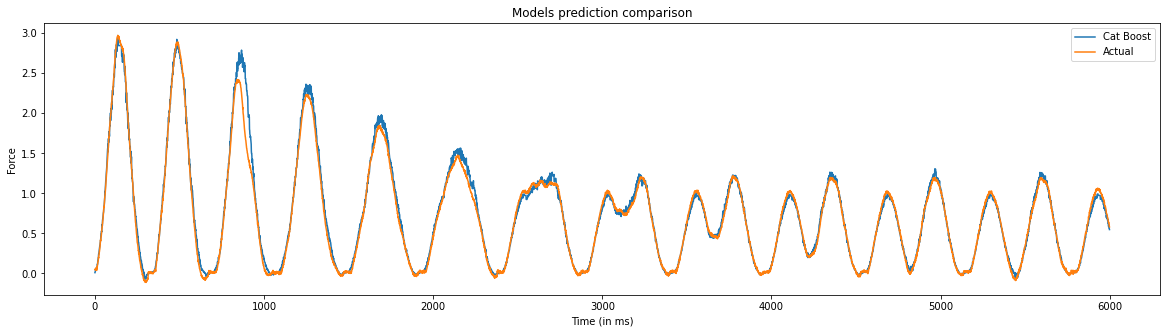

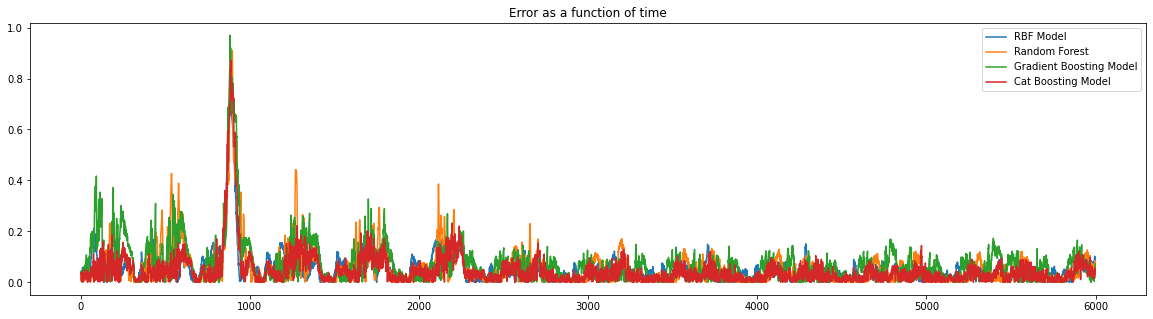

In [13]:
get_results(t=5,m=4)

Time taken by Random Forest 0:01:09.470023
Root Mean Squared error of Random Forest 0.06330334991413153
Minimum Error = 9.999999999732445e-07
Maximum Error = 0.9433290000000014
Median Value of Error = 0.021278000000000026


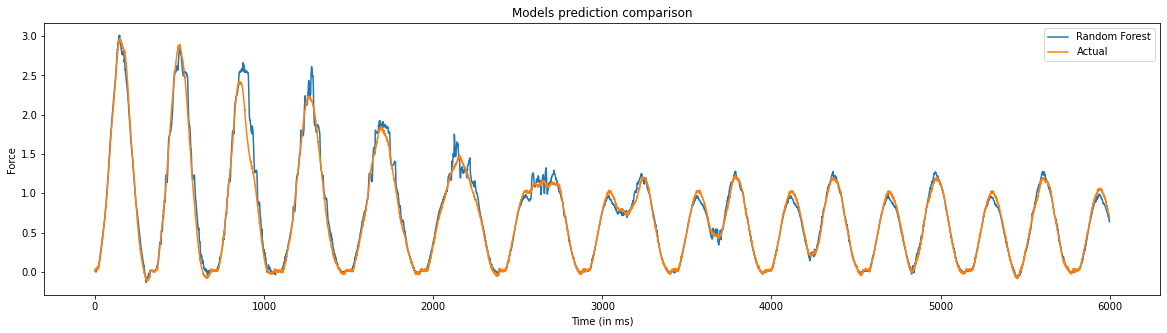



Time taken by RBF Model:  0:02:22.163814
Root mean square error of RBF Model:  0.05337451126273408
Minimum Error = [3.78970714e-07]
Maximum Error = [0.64397901]
Median Value of Error = [0.02104667]


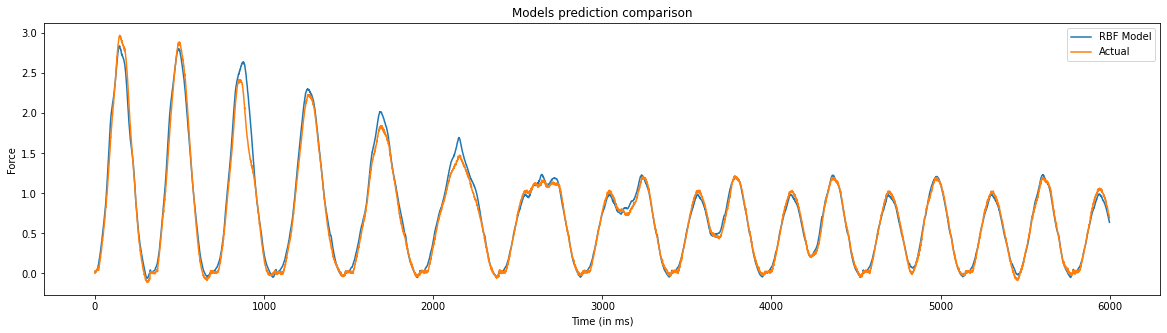

Time taken by Gradient Boosting: 0:00:21.614169
Root mean square error of Gradient Boosting Model:  0.06516510216454076
Minimum Error = 2.7263279886880626e-06
Maximum Error = 0.9868062891652198
Median Value of Error = 0.03165612517204053


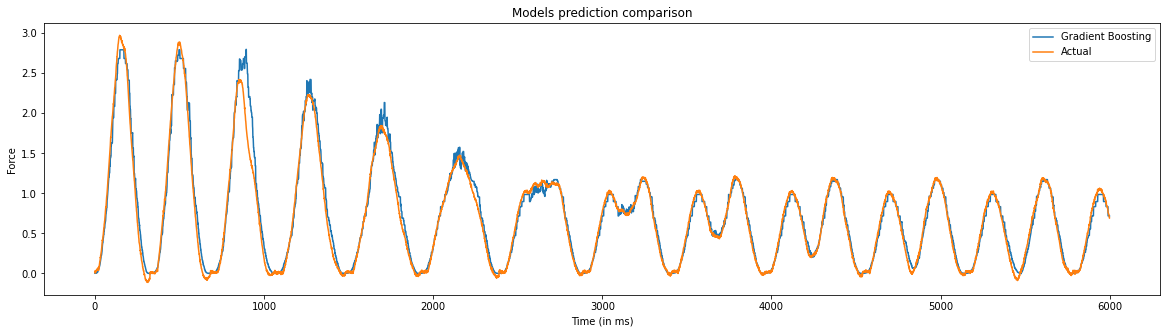

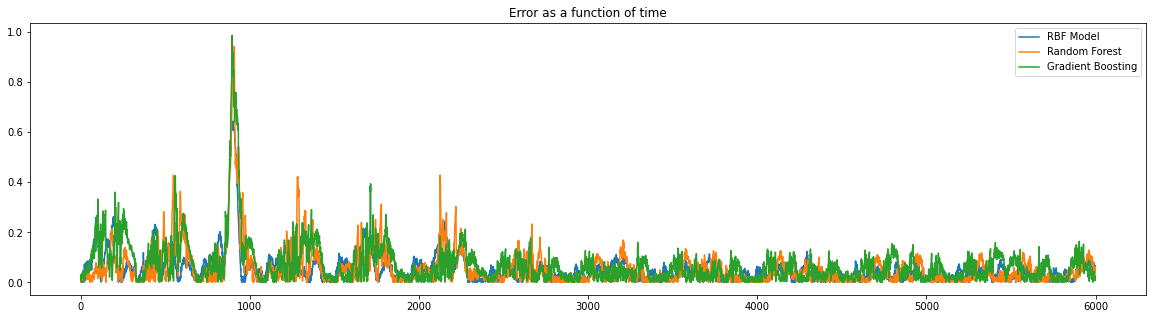

Learning rate set to 0.086821
0:	learn: 0.9231305	total: 9.08ms	remaining: 9.07s
1:	learn: 0.8476911	total: 14.6ms	remaining: 7.3s
2:	learn: 0.7782579	total: 20.6ms	remaining: 6.83s
3:	learn: 0.7145766	total: 25.3ms	remaining: 6.3s
4:	learn: 0.6565726	total: 29.9ms	remaining: 5.96s
5:	learn: 0.6036137	total: 34.6ms	remaining: 5.72s
6:	learn: 0.5558235	total: 39ms	remaining: 5.54s
7:	learn: 0.5116814	total: 44.2ms	remaining: 5.47s
8:	learn: 0.4710662	total: 48.7ms	remaining: 5.37s
9:	learn: 0.4340312	total: 53.2ms	remaining: 5.26s
10:	learn: 0.4004448	total: 57.9ms	remaining: 5.2s
11:	learn: 0.3698270	total: 62.6ms	remaining: 5.15s
12:	learn: 0.3419533	total: 67.4ms	remaining: 5.12s
13:	learn: 0.3164474	total: 72.7ms	remaining: 5.12s
14:	learn: 0.2925974	total: 77.2ms	remaining: 5.07s
15:	learn: 0.2710270	total: 81.7ms	remaining: 5.02s
16:	learn: 0.2516707	total: 86.5ms	remaining: 5s
17:	learn: 0.2341890	total: 91.2ms	remaining: 4.98s
18:	learn: 0.2182648	total: 95.9ms	remaining: 4.95s


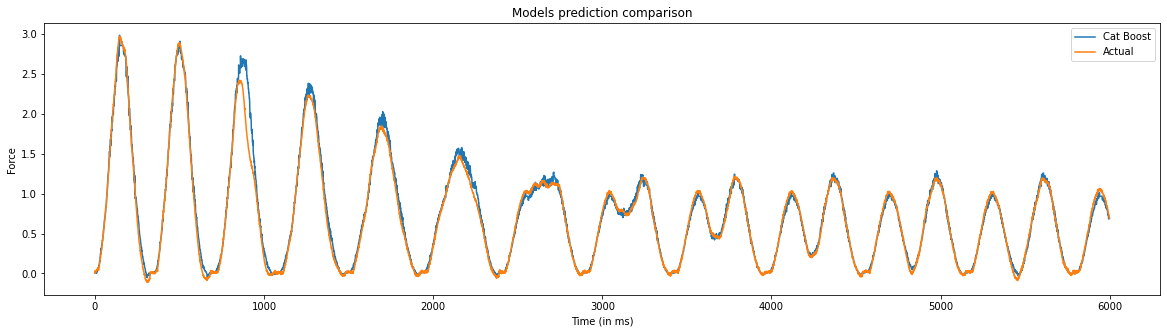

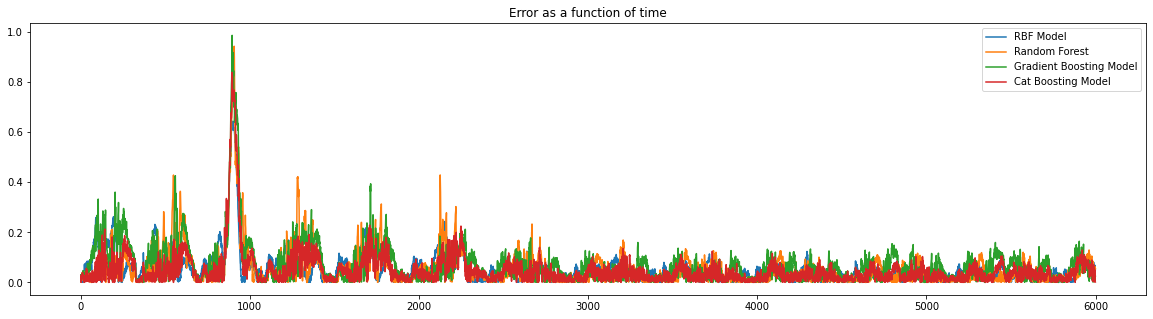

In [14]:
get_results(t=2,m=3)

Time taken by Random Forest 0:00:48.261353
Root Mean Squared error of Random Forest 0.06479690176343574
Minimum Error = 1.1102230246251565e-16
Maximum Error = 0.9447810000000001
Median Value of Error = 0.02192280714285714


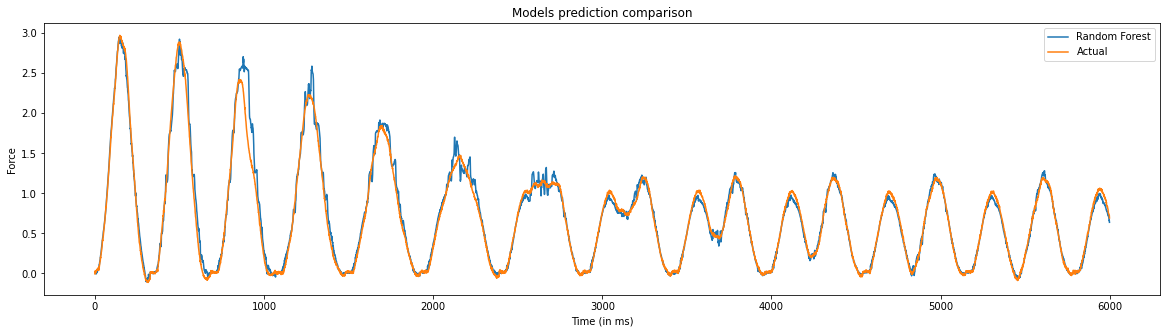



Time taken by RBF Model:  0:01:51.336271
Root mean square error of RBF Model:  0.04640604327724899
Minimum Error = [2.95478559e-08]
Maximum Error = [0.68972514]
Median Value of Error = [0.02225667]


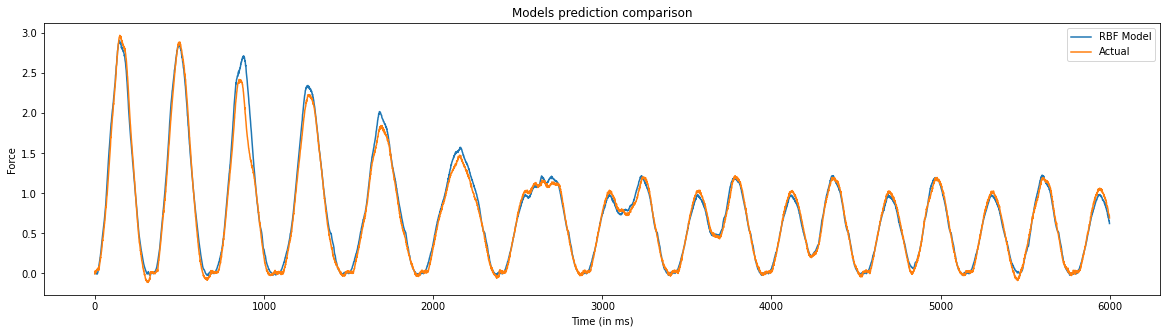

Time taken by Gradient Boosting: 0:00:14.354324
Root mean square error of Gradient Boosting Model:  0.0674045402111556
Minimum Error = 3.6587507224426774e-08
Maximum Error = 0.9301860736182692
Median Value of Error = 0.03195684385768868


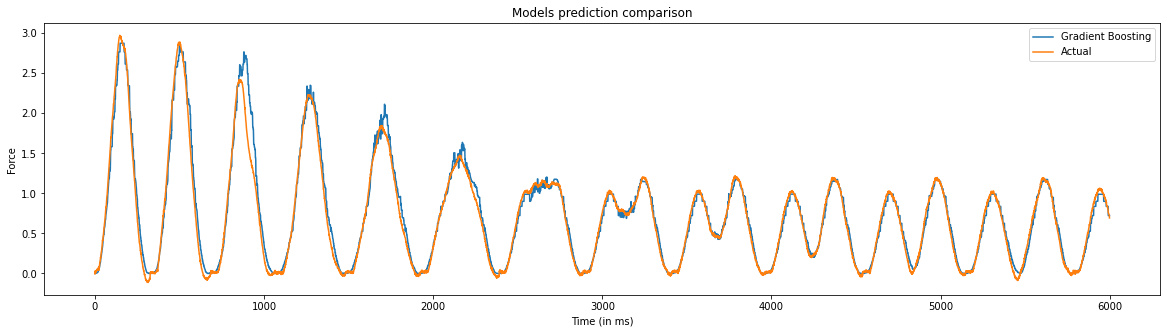

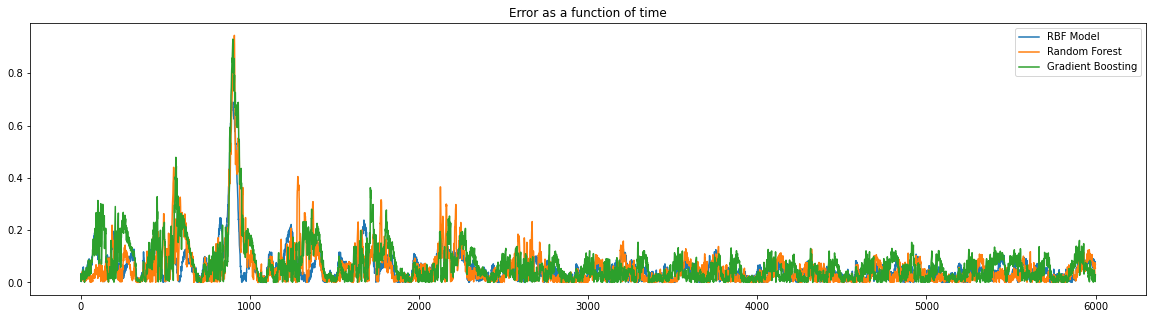

Learning rate set to 0.086821
0:	learn: 0.9230022	total: 10.5ms	remaining: 10.5s
1:	learn: 0.8474529	total: 16.6ms	remaining: 8.28s
2:	learn: 0.7780512	total: 22ms	remaining: 7.29s
3:	learn: 0.7151478	total: 26.5ms	remaining: 6.6s
4:	learn: 0.6573463	total: 30.9ms	remaining: 6.14s
5:	learn: 0.6042047	total: 35.3ms	remaining: 5.84s
6:	learn: 0.5555084	total: 41.1ms	remaining: 5.83s
7:	learn: 0.5112878	total: 46ms	remaining: 5.7s
8:	learn: 0.4708492	total: 50.8ms	remaining: 5.59s
9:	learn: 0.4338065	total: 55.5ms	remaining: 5.5s
10:	learn: 0.4002020	total: 60ms	remaining: 5.4s
11:	learn: 0.3691562	total: 64.6ms	remaining: 5.32s
12:	learn: 0.3410585	total: 69.2ms	remaining: 5.25s
13:	learn: 0.3149718	total: 73.5ms	remaining: 5.18s
14:	learn: 0.2917277	total: 78.3ms	remaining: 5.14s
15:	learn: 0.2703020	total: 83.3ms	remaining: 5.12s
16:	learn: 0.2509974	total: 88ms	remaining: 5.09s
17:	learn: 0.2331050	total: 92.5ms	remaining: 5.04s
18:	learn: 0.2168521	total: 96.7ms	remaining: 4.99s
19:	

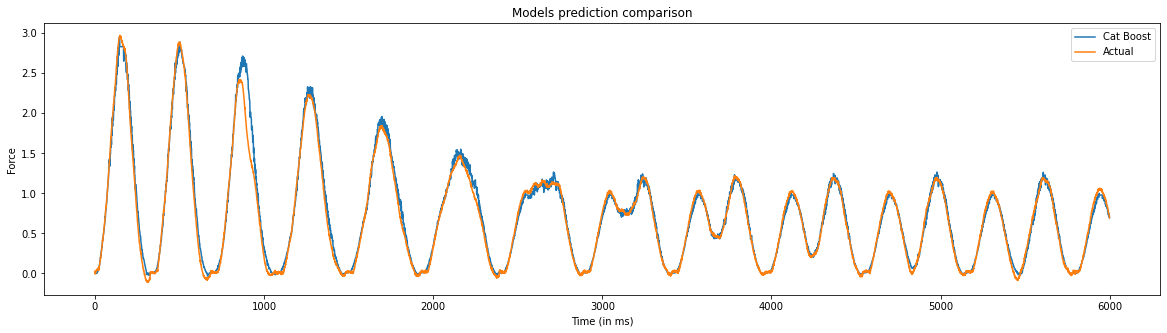

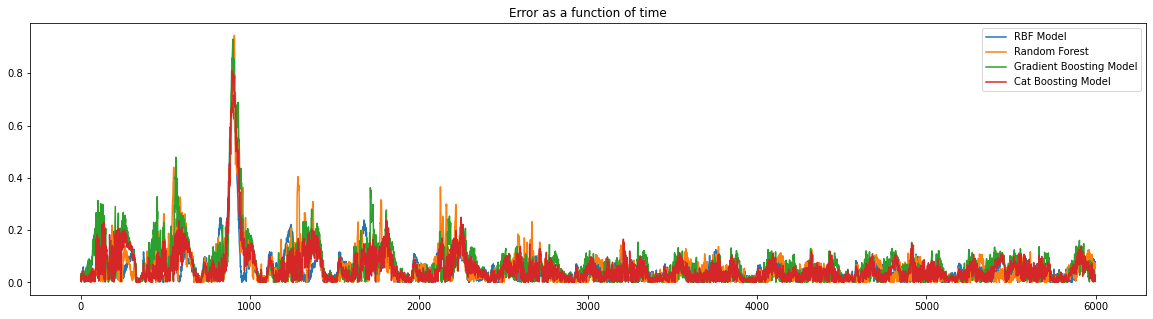

In [15]:
get_results(t=3,m=2)